In [1]:
import xarray as xr
from glob import glob
from datetime import datetime
import yaml
import sys
sys.path.append('../../')

import plotting

from ecco_pipeline.baseclasses import Grid
from ecco_pipeline.conf.global_settings import OUTPUT_DIR
from ecco_pipeline.utils.pipeline_utils.file_utils import get_date
from ecco_pipeline.transformations.grid_transformation import Transformation

In [2]:
ds_name = "MODIS_AQUA_L3_SST_THERMAL_DAILY_9KM_DAYTIME_V2019.0"
hemisphere = ''
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [3]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.nc*')
if hemisphere:
    ds_granules = [g for g in ds_granules if hemisphere in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/MODIS_AQUA_L3_SST_THERMAL_DAILY_9KM_DAYTIME_V2019.0/harvested_granules/2023/AQUA_MODIS.20230427.L3m.DAY.SST.sst.9km.NRT.nc


In [4]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = xr.open_dataset(sample_granule_path)
ds

<xarray.Dataset>
Dimensions:   (lat: 2160, lon: 4320, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat       (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon       (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    sst       (lat, lon) float32 ...
    qual_sst  (lat, lon) float32 ...
    palette   (rgb, eightbitcolor) uint8 ...
Attributes: (12/62)
    product_name:                     AQUA_MODIS.20230427.L3m.DAY.SST.sst.9km...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    source:                           satellite observations from MODIS-Aqua
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Optics >...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        1864379
    data_minimum:                     -1.7900001
    data_maximum:                     39.995

# Load grid

In [5]:
grids = glob('grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/TPOSE.nc', 'grids/polar_stereo_n_25km.nc']"

In [6]:
grid_ds = xr.open_dataset(grids[1])
target_grid = Grid(grid_ds)
target_grid.ds

<xarray.Dataset>
Dimensions:                (tile: 13, j: 90, i: 90)
Coordinates:
  * tile                   (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                      (j) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i                      (i) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Data variables:
    XC                     (tile, j, i) float32 ...
    YC                     (tile, j, i) float32 ...
    effective_grid_radius  (tile, j, i) float32 ...
Attributes:
    name:                  ECCO_llc90
    type:                  llc
    geospatial_lat_min:    -89.873055
    geospatial_lat_max:    89.739395
    geospatial_lon_min:    -179.98895
    geospatial_lon_max:    179.98691
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [7]:
T = Transformation(config, sample_granule_path, granule_date)

# Make mapping factors

In [8]:
factors = T.make_factors(target_grid)

Only using 100 nearest neighbours, but you may need up to 516450244
Creating ECCO_llc90 mapping factors...done.


# Transformation

In [9]:
field_ds_list = T.transform(target_grid, factors, ds)

In [10]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                         (time: 1, tile: 13, j: 90, i: 90, nv: 2)
Coordinates:
  * time                            (time) datetime64[ns] 2023-04-27T12:00:00
  * tile                            (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                               (j) int16 0 1 2 3 4 5 ... 84 85 86 87 88 89
  * i                               (i) int16 0 1 2 3 4 5 ... 84 85 86 87 88 89
    XC                              (tile, j, i) float32 -111.6 ... -111.9
    YC                              (tile, j, i) float32 -88.24 -88.38 ... -88.1
    time_bnds                       (time, nv) datetime64[ns] 2023-04-27 2023...
Dimensions without coordinates: nv
Data variables:
    sst_interpolated_to_ECCO_llc90  (time, tile, j, i) float64 9.969e+36 ... ...
Attributes:
    interpolated_grid:            ECCO_llc90
    model_grid_type:              llc
    original_dataset_title:       MODIS Aqua Level 3 SST Thermal IR Daily 9km...
    original_dataset_short_name:  MODIS_AQUA_L3_SST_THERMAL_DAILY_9KM_DAYTIME...
    original_dataset_url:         https://podaac.jpl.nasa.gov/dataset/MODIS_A...
    original_dataset_reference:   http://oceancolor.gsfc.nasa.gov
    original_dataset_doi:         10.5067/MODSA-1D9D9
    interpolated_grid_id:         ECCO_llc90
    transformation_version:       1.5
    notes:

# Visualization

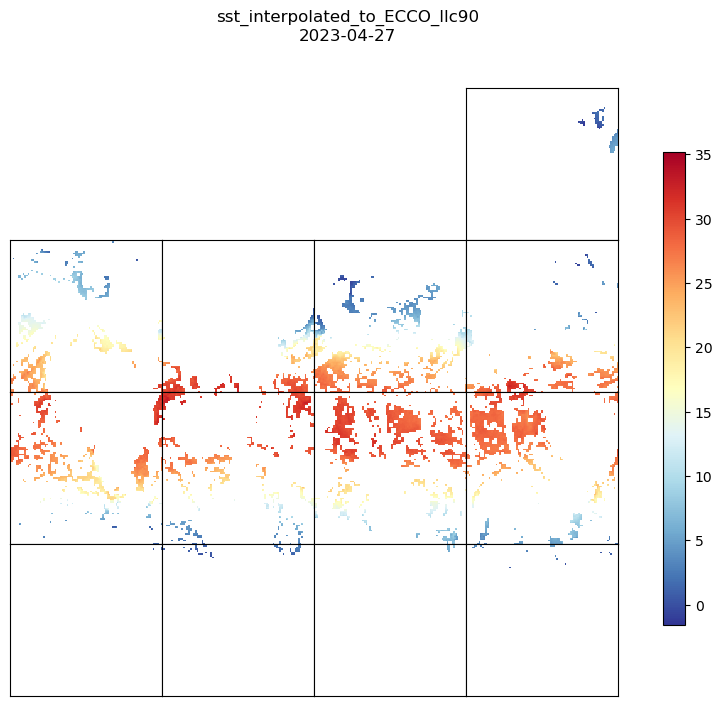

In [11]:
for field_ds in field_ds_list:
    plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]])
